# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from PIL import Image

In [3]:
DATA_DIR = "./data/coco"

IMG_HEIGHT = 244
IMG_WIDTH = 244

SEED = 1

In [4]:
# Setup GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Load Data

In [5]:
# Load Image data
images = {}
image_dir = DATA_DIR + "/val2017/"
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        img = tf.io.read_file(image_dir + filename)
        images[int(filename[:-4])] = tf.image.decode_jpeg(img, channels=3)

In [6]:
# Load bbox/annotations
with open(DATA_DIR + "/annotations/instances_val2017.json") as f:
    _ = json.load(f)
    categories = {entry["id"]:{
            "supercategory": entry["supercategory"],
            "name": entry["name"]
        } for entry in _["categories"]}
    instances = {entry["id"]:{
            "bbox": tuple(entry["bbox"]),
            "category_id": entry["category_id"],
            "image_id": entry["image_id"]
        } for entry in _["annotations"]}

## Sanity checks

In [7]:
print("{} instances of {} categories contained in {} images".format(len(instances), len(categories), len(images)))

36781 instances of 80 categories contained in 5000 images


In [8]:
from multiagent.util.bbox import draw_bbox, draw_cross

def annotation_sanity_test(instance_id = None):
    instance_id = instance_id or np.random.choice(list(instances.keys()))
    instance = instances[instance_id]
    image_id = instance["image_id"]
    image_tensor = images[image_id]
    image = Image.fromarray(np.asarray(image_tensor))
    category = categories[instance["category_id"]]
    bbox = instance["bbox"]
    print("Drawing bbox {} of instance {} which is a '{}' in image {}".format(bbox,instance_id, category["name"], image_id))
    return draw_bbox(image, bbox)


def find_all_instances(image_id, category_id):
    target_bboxs, keys = [], []
    for key, instance in instances.items():
        if instance['image_id'] == image_id and instance['category_id'] == category_id:
            target_bboxs.append(instance)
            keys.append(key)
    return keys, target_bboxs


def draw_all_bboxs(image_id, category_id):
    keys, drawn_instances = find_all_instances(image_id, category_id)
    image_tensor = images[image_id]
    image = Image.fromarray(np.asarray(image_tensor))
    for inst in drawn_instances:
        image = draw_bbox(image, inst['bbox'])
    return image

def test_draw_cross(instance_id = None):
    instance_id = instance_id or np.random.choice(list(instances.keys()))
    instance = instances[instance_id]
    image_id = instance["image_id"]
    image_tensor = images[image_id]
    image = Image.fromarray(np.asarray(image_tensor))
    category = categories[instance["category_id"]]
    bbox = instance["bbox"]
    print("Drawing bbox {} of instance {} which is a '{}' in image {}".format(bbox,instance_id, category["name"], image_id))
    image = draw_bbox(image, bbox)
    return draw_cross(image, bbox)

Drawing bbox (452.32, 175.87, 49.65, 75.55) of instance 209047 which is a 'person' in image 275198


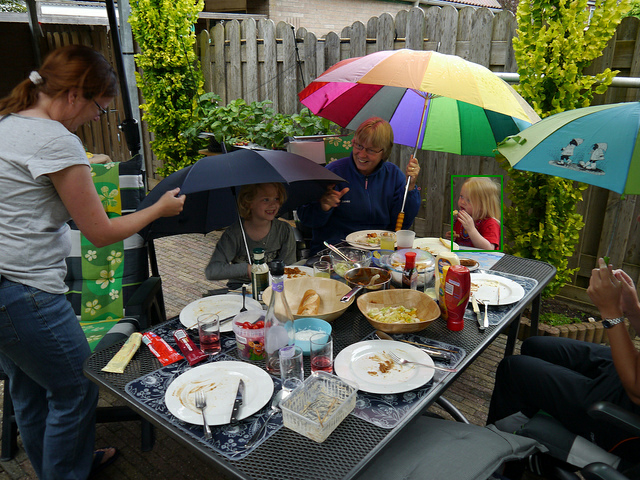

In [9]:
annotation_sanity_test(209047)

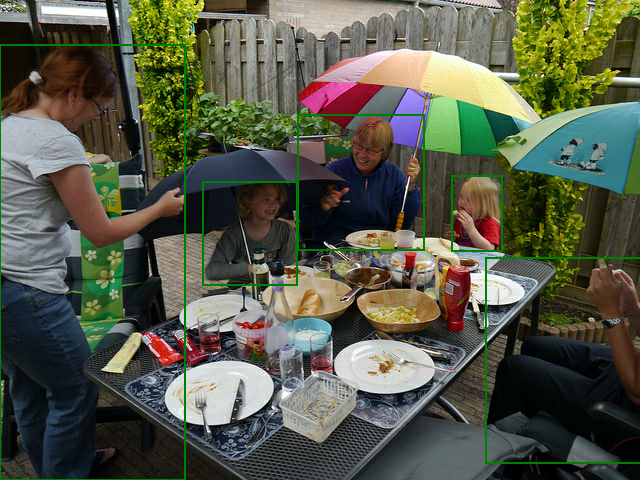

In [10]:
draw_all_bboxs(275198, 1)

Drawing bbox (452.32, 175.87, 49.65, 75.55) of instance 209047 which is a 'person' in image 275198


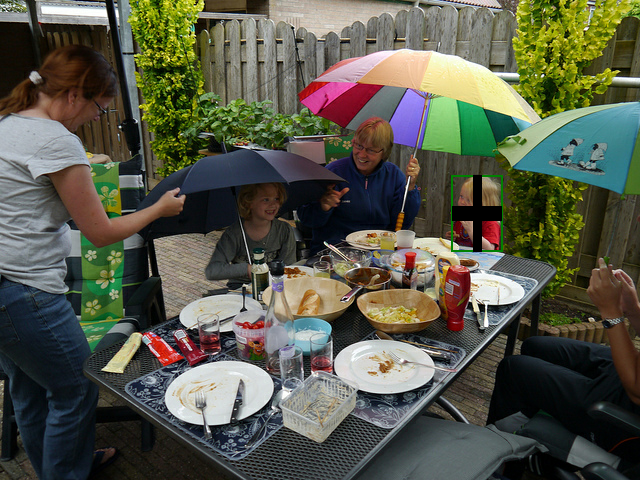

In [11]:
test_draw_cross(209047)

# Setting up feature extractors and Environment

In [12]:
from multiagent.infrastructure.env import ObjectLocalizationEnv

In [14]:
model = tf.keras.models.Sequential(tf.keras.applications.VGG16(weights="imagenet", include_top = True).layers[:-2])

env = ObjectLocalizationEnv(model, (224, 224), feature_dim = 4096)

# Env sanity checks (multiple instances)

In [43]:
image_id = 275198
image_tensor = tf.expand_dims(images[image_id], 0)
target_bboxs = [bbox["bbox"] for bbox in find_all_instances(275198, 1)[1]]

env.reset(target_bboxs, image_tensor)
env.training_reset()

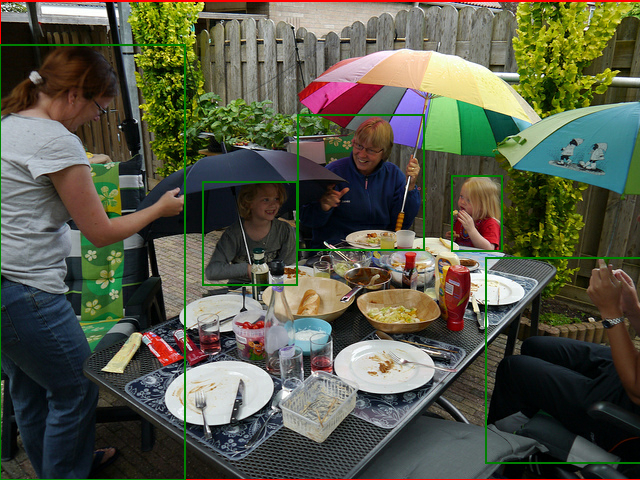

In [44]:
env.show()

In [45]:
print("Positive Actions:", env._positive_actions_idx())
action =  env.get_random_expert_action()
action

Positive Actions: []


array([0., 1., 0., 0., 0., 0., 0., 0., 0.])

Reward: -1.0


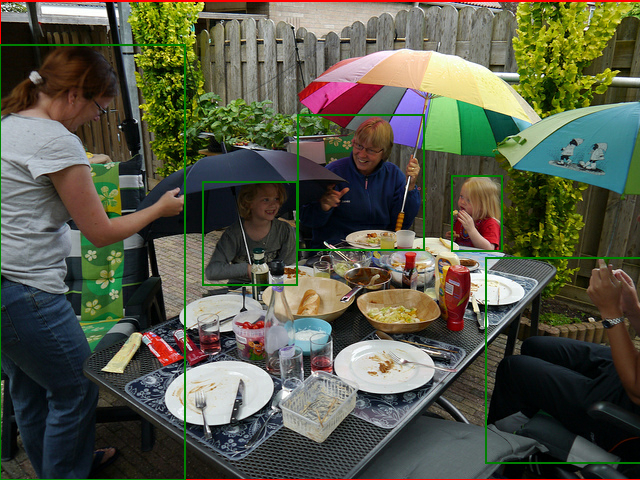

In [48]:
_, reward, _ = env.step(action)
print("Reward:", reward.numpy()[0])
env.show()

# Training  (multiple instances)

In [51]:
from multiagent.infrastructure.trainer import RL_Trainer
from multiagent.agents.dqn_agent import DQN_Agent
from multiagent.util.dqn_utils import LinearSchedule

In [52]:
# TODO: Figure what the hell these things should be
agent_params = {
    "replay_buffer_size": 200,
    "batch_size": 32,
    "gamma": 0.1,
    "epsilon": LinearSchedule(500, final_p = 0.1, initial_p = 1),
    "dropout": 0.1
}

params = {
    "learning_freq": 1,
    "seed": SEED,
    "agent_class": DQN_Agent,
    "optimizer": tf.keras.optimizers.Adam(learning_rate = 0.001),
    "loss": tf.keras.losses.MSE,
    "agent_params": agent_params,
    "env": env,
    "max_path_length": 10
}

5

In [54]:
env.training_reset()
len(env.target_bboxs)

5

In [53]:
trainer = RL_Trainer(params = params)

In [ ]:
returns, losses = trainer.run_training_loop(200)

# Testing

In [ ]:
agent = trainer.agent
env = trainer.env

In [ ]:
env.training_reset()
env.show()

In [ ]:
obs = env.get_env_state()
acs = agent.get_action(obs)
acs

In [ ]:
pred_q_vals = agent.q_func.predict(obs)
pred_q_vals

In [ ]:
print("Pre BBOX: \t",env.obs_bbox)
next_obs, rew, done  = env.step(acs)
print("Post BBOS:\t",env.obs_bbox)
print("Reward:", rew.numpy())
env.show()

In [ ]:
obs, acs, rew, next_obs, done = [obs], [acs], [rew], [next_obs], [done]
obs, acs, rew, next_obs, done = np.array(obs), np.array(acs), np.array(rew), np.array(next_obs), np.array(done)
target_q_vals = agent._get_target_q_vals(pred_q_vals, acs, rew, next_obs, done, 1)
target_q_vals

In [ ]:
agent.loss(target_q_vals, pred_q_vals)

# Env sanity checks (one instance)

In [55]:
instance_id = 46374
instance = instances[instance_id]
target_bbox = instance["bbox"]
image_id = instance["image_id"]
image_tensor = tf.expand_dims(images[image_id], 0)

env.reset(target_bbox, image_tensor)

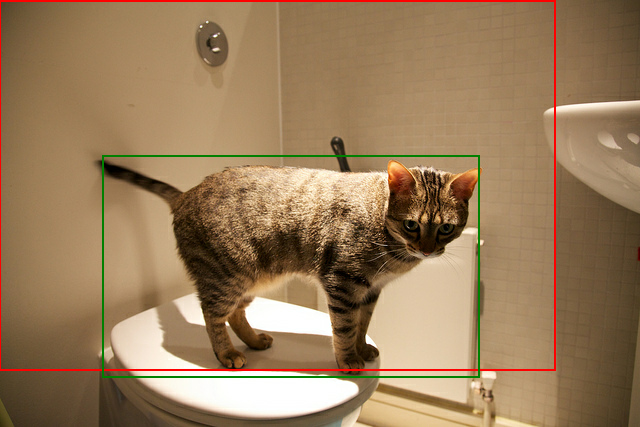

In [56]:
env.show()

In [57]:
print("Positive Actions:", env._positive_actions_idx())
action =  env.get_random_expert_action()
action

Positive Actions: [3, 5, 7]


array([0., 0., 0., 0., 0., 1., 0., 0., 0.])

Pre BBOX: 	 [0, 0, 554, 370]
Post BBOS:	 [111, 74, 332, 222]


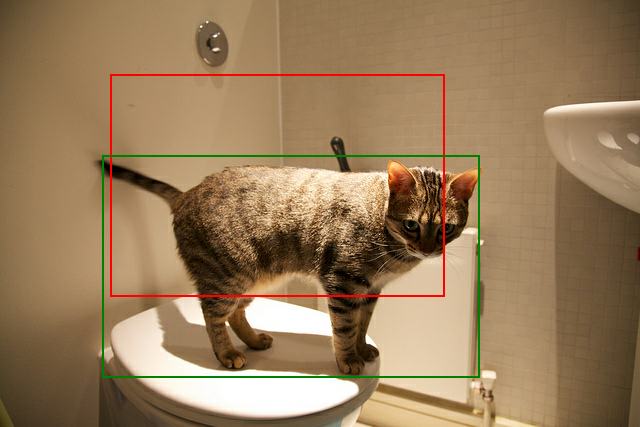

In [58]:
print("Pre BBOX: \t",env.obs_bbox)
env.step(action)
print("Post BBOS:\t",env.obs_bbox)
env.show()

# Training (One instance)

In [ ]:
from multiagent.infrastructure.trainer import RL_Trainer
from multiagent.agents.dqn_agent import DQN_Agent
from multiagent.util.dqn_utils import LinearSchedule

In [ ]:
# TODO: Figure what the hell these things should be
agent_params = {
    "replay_buffer_size": 200,
    "batch_size": 32,
    "gamma": 0.1,
    "epsilon": LinearSchedule(200, final_p = 0.1, initial_p = 1),
    "dropout": 0.1
}

params = {
    "learning_freq": 1,
    "seed": SEED,
    "agent_class": DQN_Agent,
    "optimizer": tf.keras.optimizers.Adam(learning_rate = 0.001),
    "loss": tf.keras.losses.Huber(),
    "agent_params": agent_params,
    "env": env,
    "max_path_length": 5
}

In [ ]:
env.reset(target_bbox, image_tensor)
env.training_reset()

In [ ]:
trainer = RL_Trainer(params = params)

In [ ]:
returns, losses = trainer.run_training_loop(200)

# Testing (one instance)

In [ ]:
agent = trainer.agent
env = trainer.agent.env

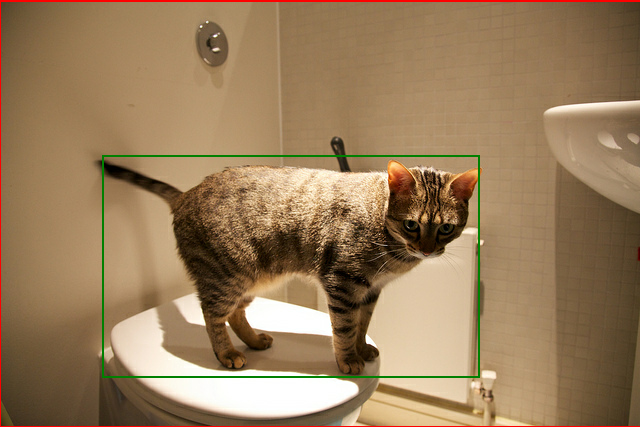

In [60]:
env.reset(target_bbox, image_tensor)
env.training_reset()
env.show()

In [ ]:
obs = env.get_env_state()
acs = agent.get_action(obs)
acs


In [ ]:
pred_q_vals = agent.q_func.predict(obs)
pred_q_vals

In [ ]:
print("Pre BBOX: \t",env.obs_bbox)
next_obs, rew, done  = env.step(acs)
print("Post BBOS:\t",env.obs_bbox)
print("Reward:", rew.numpy())
env.show()

In [ ]:
obs, acs, rew, next_obs, done = [obs], [acs], [rew], [next_obs], [done]
obs, acs, rew, next_obs, done = np.array(obs), np.array(acs), np.array(rew), np.array(next_obs), np.array(done)
target_q_vals = agent._get_target_q_vals(pred_q_vals, acs, rew, next_obs, done, 1)
target_q_vals

In [ ]:
agent.loss(target_q_vals, pred_q_vals)